<a href="https://colab.research.google.com/github/VictorFu0717/AI/blob/main/Alzheimer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# 連接kaggle api
api_token = {"username":"victor830717","key":"e5ff0036288b15a13b2e2e4444e5051b"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
# !kaggle datasets download -d kaggle資料集名稱 --force
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset --force
 
!ls /kaggle

 95% 361M/380M [00:01<00:00, 240MB/s]
100% 380M/380M [00:01<00:00, 204MB/s]
augmented-alzheimer-mri-dataset.zip  kaggle


In [14]:
! unzip augmented-alzheimer-mri-dataset.zip -d kaggle

Archive:  augmented-alzheimer-mri-dataset.zip
replace kaggle/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [24]:
data = "/kaggle/kaggle/AugmentedAlzheimerDataset"
image_dir = Path(data)


# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/kaggle/kaggle/AugmentedAlzheimerDataset/NonDe...,NonDemented
1,/kaggle/kaggle/AugmentedAlzheimerDataset/NonDe...,NonDemented
2,/kaggle/kaggle/AugmentedAlzheimerDataset/NonDe...,NonDemented
3,/kaggle/kaggle/AugmentedAlzheimerDataset/NonDe...,NonDemented
4,/kaggle/kaggle/AugmentedAlzheimerDataset/NonDe...,NonDemented
...,...,...
33979,/kaggle/kaggle/AugmentedAlzheimerDataset/VeryM...,VeryMildDemented
33980,/kaggle/kaggle/AugmentedAlzheimerDataset/VeryM...,VeryMildDemented
33981,/kaggle/kaggle/AugmentedAlzheimerDataset/VeryM...,VeryMildDemented
33982,/kaggle/kaggle/AugmentedAlzheimerDataset/VeryM...,VeryMildDemented


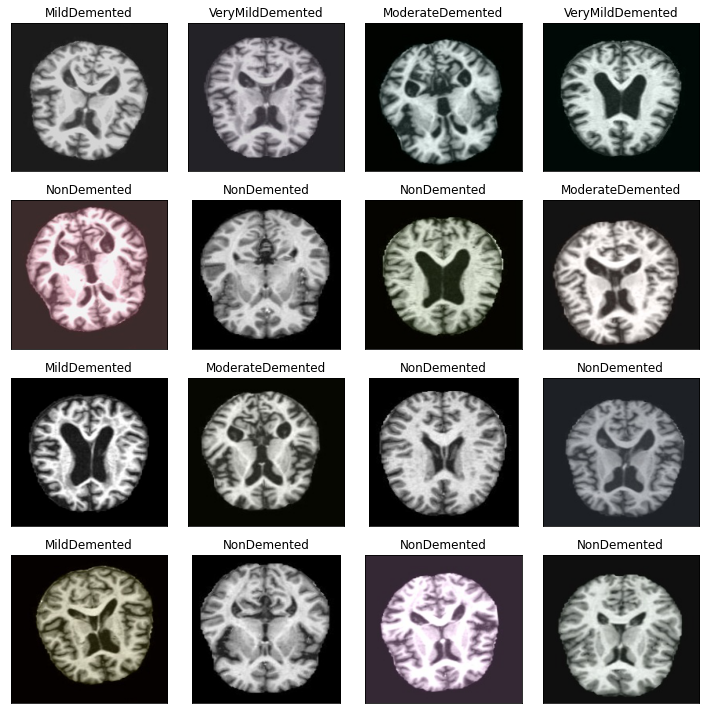

In [25]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [18]:
# from sklearn.model_selection import train_test_split
# import glob
# X_train, X_test, y_train, y_test = train_test_split(image_df['Filepath'], image_df['Label'], test_size=0.2)


In [26]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D 
#flatten 讓他變成同一個維度
#第一層param: 64 * (1個filter)27 + 64bias = 1792
#第二層param: 128 * 576 + 128bias =  73856
layers = [
    # 一個filter(27) * 64 + 64(bias)
    Conv2D(32, 3, padding="same", activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(),
    # 576 * 128 + 128
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(4, activation="softmax")
]
model = Sequential(layers)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 256)     

In [28]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 99s 115ms/step - loss: 1.3351 - accuracy: 0.3146 - val_loss: 1.2173 - val_accuracy: 0.4172
Epoch 2/10
850/850 [==============================] - 96s 113ms/step - loss: 1.0088 - accuracy: 0.5263 - val_loss: 0.8548 - val_accuracy: 0.6127
Epoch 3/10
850/850 [==============================] - 96s 113ms/step - loss: 0.7830 - accuracy: 0.6367 - val_loss: 0.7440 - val_accuracy: 0.6632
Epoch 4/10
850/850 [==============================] - 96s 113ms/step - loss: 0.6866 - accuracy: 0.6852 - val_loss: 0.6328 - val_accuracy: 0.7237
Epoch 5/10
850/850 [==============================] - 97s 114ms/step - loss: 0.6011 - accuracy: 0.7375 - val_loss: 0.5660 - val_accuracy: 0.7663
Epoch 6/10
850/850 [==============================] - 97s 114ms/step - loss: 0.5205 - accuracy: 0.7754 - val_loss: 0.4808 - val_accuracy: 0.7987
Epoch 7/10
850/850 [==============================] - 97s 114ms/step - loss: 0.4529 - accuracy: 0.8091 - val_loss: 0.3973 - val_ac

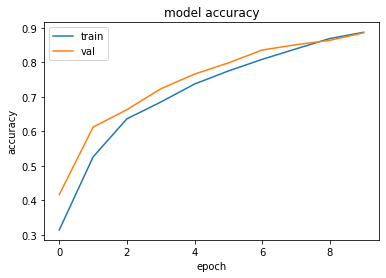

In [29]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

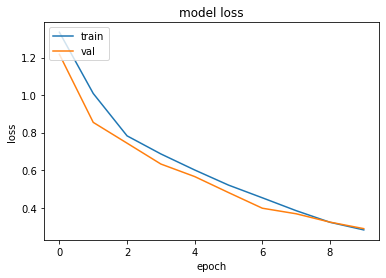

In [30]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()